In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

import datetime

In [2]:
df = pd.read_pickle("datos/5.cnt_encoding_estandarizacion.pkl")
df.head()

,dteday,yr,mnth,dia_anual,holiday_num,weekday_num,workingday_num,weathersit,cnt,seasons_autumn,seasons_spring,seasons_summer,seasons_winter,temp,atemp,hum,windspeed,casual,registered
0,2018-01-01,0,1,1,1,0,0,2,985,0.0,0.0,0.0,1.0,-0.486274,-0.456399,0.863588,-0.216120,-0.494713,-1.319816
1,2018-01-02,0,1,2,0,1,1,2,801,0.0,0.0,0.0,1.0,-0.425690,-0.492863,0.335222,0.711284,-0.751041,-1.312801
2,2018-01-03,0,1,3,0,2,1,1,1349,0.0,0.0,0.0,1.0,-0.949970,-1.098990,-0.910822,0.708863,-0.765139,-1.067733
3,2018-01-04,0,1,4,0,3,1,1,1562,0.0,0.0,0.0,1.0,-0.938563,-1.015201,-0.173433,-0.217699,-0.780519,-0.969093
4,2018-01-05,0,1,5,0,4,1,1,1600,0.0,0.0,0.0,1.0,-0.853992,-0.951952,-0.912344,0.062376,-0.813842,-0.941035


In [3]:
df.dtypes

dteday              object
yr                category
mnth              category
dia_anual         category
holiday_num       category
weekday_num       category
workingday_num    category
weathersit        category
cnt                  int64
seasons_autumn    category
seasons_spring    category
seasons_summer    category
seasons_winter    category
temp               float64
atemp              float64
hum                float64
windspeed          float64
casual             float64
registered         float64
dtype: object

In [4]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df[['holiday_num', 'weekday_num', 'workingday_num', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'seasons_autumn', 'seasons_spring', 'seasons_summer', 'seasons_winter']]
y = df["cnt"]

In [5]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [7]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.4641016151377544

In [8]:
# max depth

print(arbol.tree_.max_depth)

25


In [9]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "CNT_est_ Decission Tree I Est-Cod")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1334.821918,2.897784e+06,1702.287908,0.153398,test,CNT_est_ Decission Tree I Est-Cod
1,0.000000,0.000000e+00,0.000000,1.000000,train,CNT_est_ Decission Tree I Est-Cod


In [12]:
df.shape

(730, 19)

Overfitting

In [13]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [4,6,8],
        "max_features": [4,5,6,7],
        "min_samples_split": [5, 20, 75], 
        "min_samples_leaf": [5,20,75]} 

In [14]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [15]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 20, 75],
                         'min_samples_split': [5, 20, 75]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [16]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=5, min_samples_leaf=5,
                      min_samples_split=20)

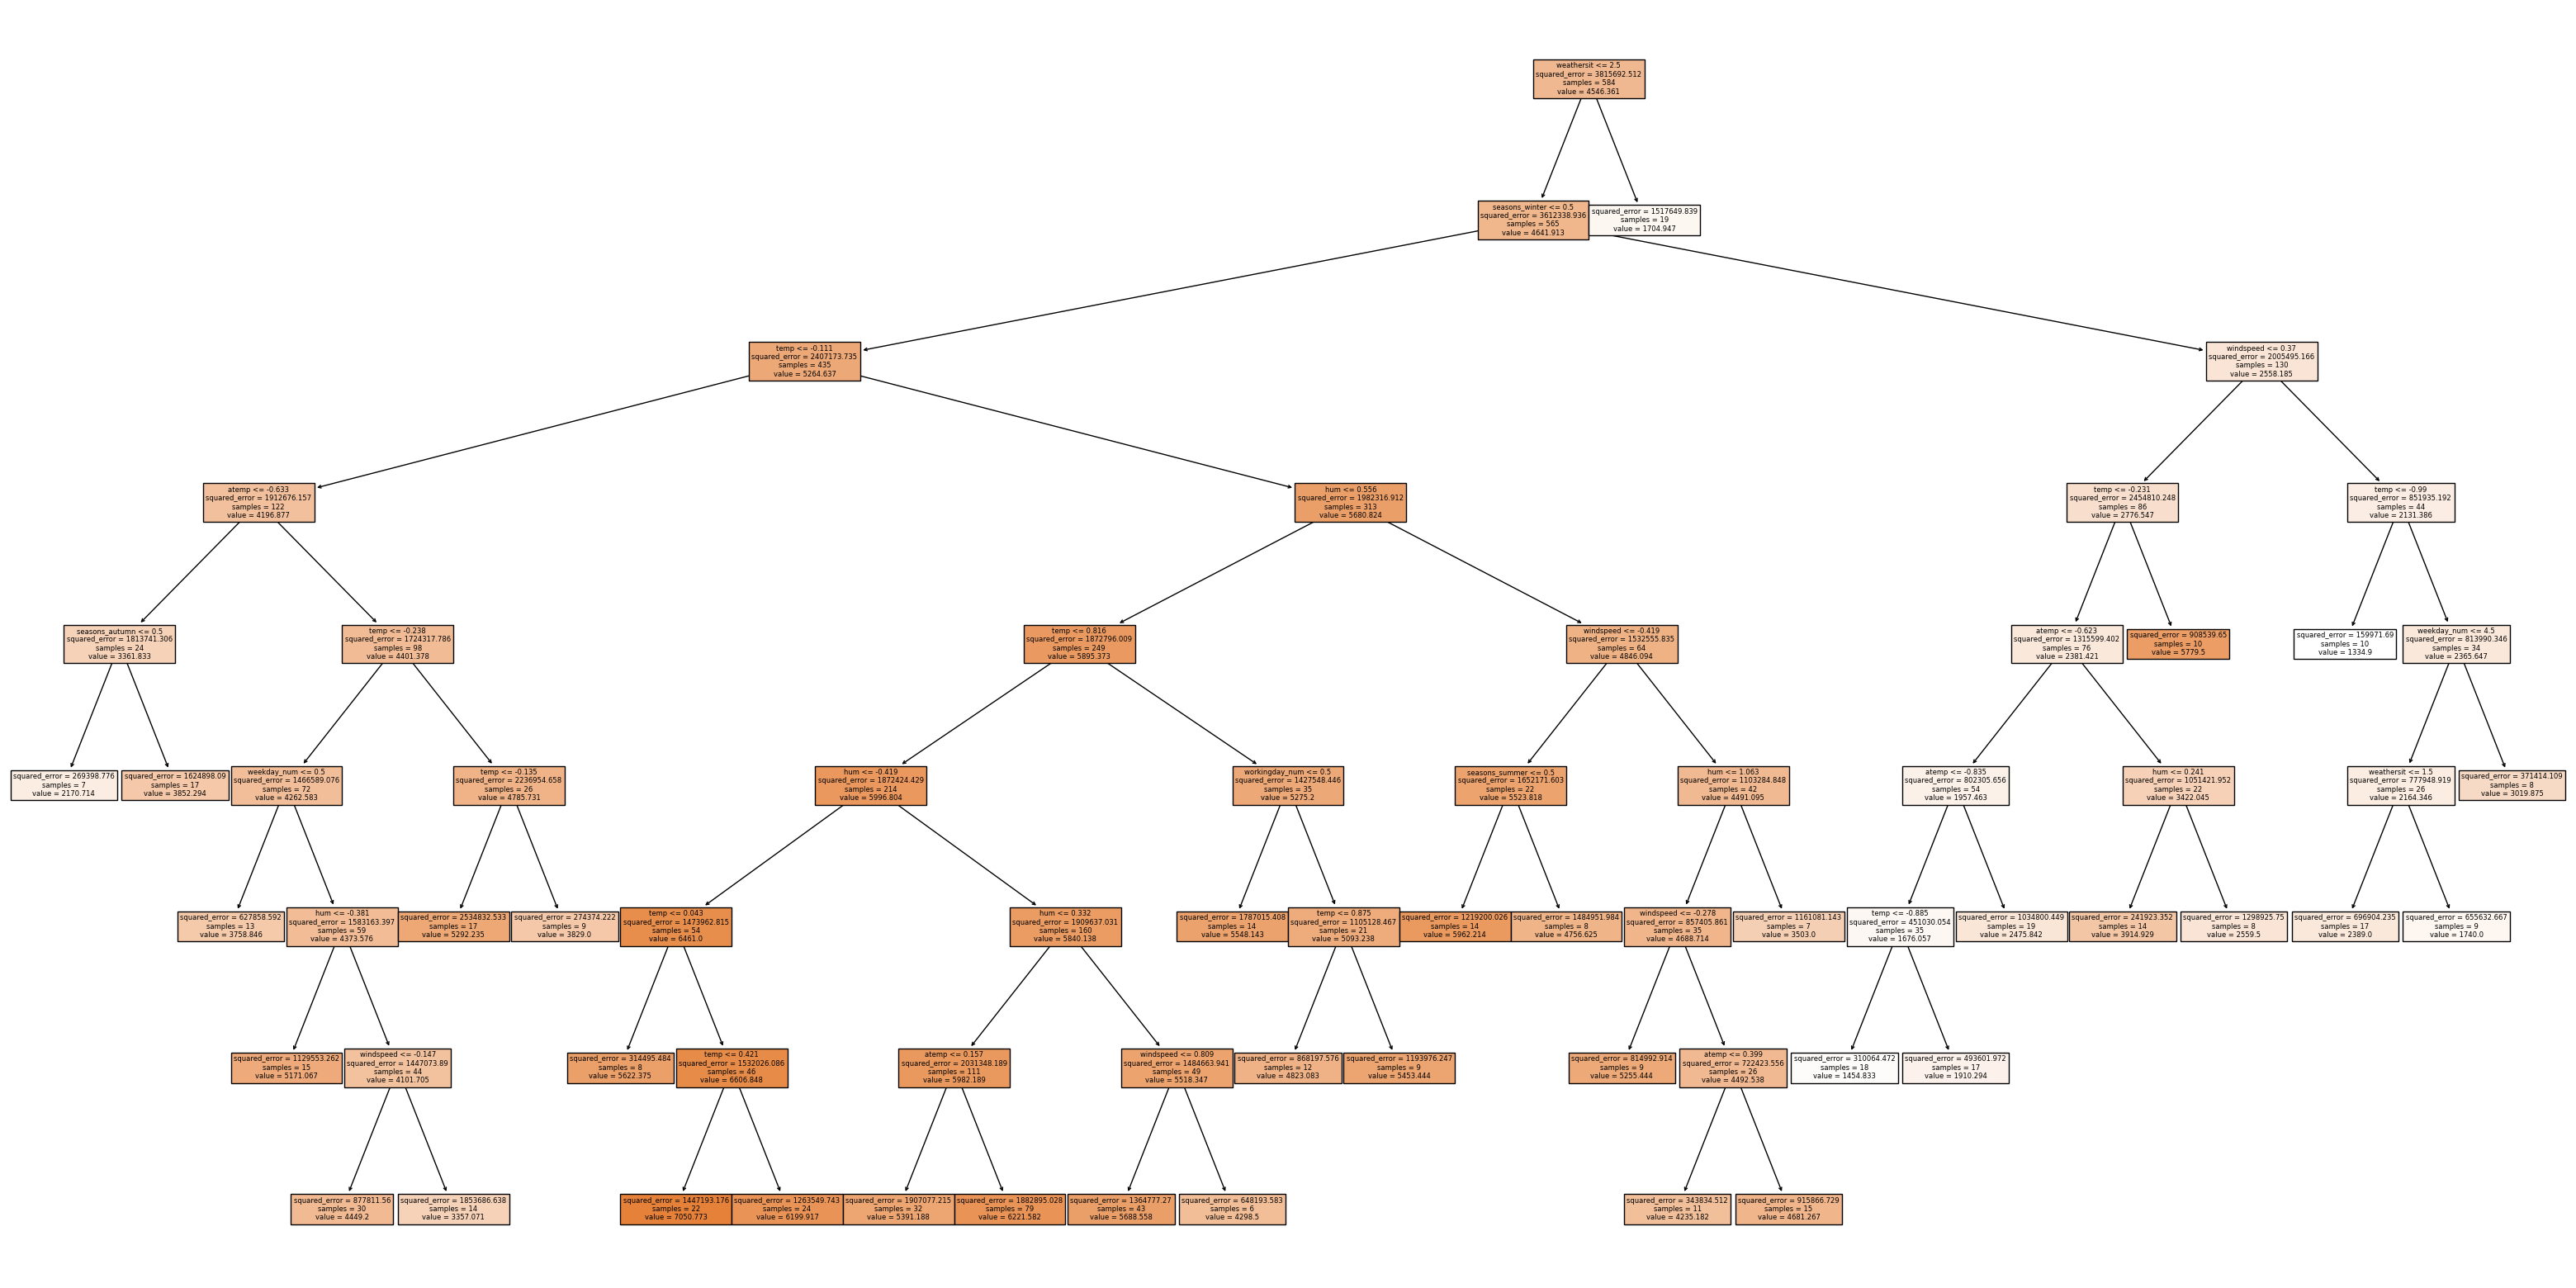

In [17]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [18]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [19]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "CNT_est_ Decision tree II Est-Cod")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,1156.178519,1.970333e+06,1403.685382,0.424358,test,CNT_est_ Decision tree II Est-Cod
1,898.989340,1.207631e+06,1098.922588,0.683509,train,CNT_est_ Decision tree II Est-Cod


In [20]:
df.head(2)

,dteday,yr,mnth,dia_anual,holiday_num,weekday_num,workingday_num,weathersit,cnt,seasons_autumn,seasons_spring,seasons_summer,seasons_winter,temp,atemp,hum,windspeed,casual,registered
0,2018-01-01,0,1,1,1,0,0,2,985,0.0,0.0,0.0,1.0,-0.486274,-0.456399,0.863588,-0.216120,-0.494713,-1.319816
1,2018-01-02,0,1,2,0,1,1,2,801,0.0,0.0,0.0,1.0,-0.425690,-0.492863,0.335222,0.711284,-0.751041,-1.312801


In [21]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0).reset_index(drop=True)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1334.821918,2.897784e+06,1702.287908,0.153398,test,CNT_est_ Decission Tree I Est-Cod
1,0.000000,0.000000e+00,0.000000,1.000000,train,CNT_est_ Decission Tree I Est-Cod
2,1156.178519,1.970333e+06,1403.685382,0.424358,test,CNT_est_ Decision tree II Est-Cod
3,898.989340,1.207631e+06,1098.922588,0.683509,train,CNT_est_ Decision tree II Est-Cod


In [22]:
#df_decision_results.style.background_gradient()

In [23]:
df_DT1 = pd.read_csv("datos/6.cnt_resultados_1_cod.csv", index_col = 0)
df_DT1

,MAE,MSE,RMSE,R2,set,modelo
0,1334.821918,2.897784e+06,1702.287908,0.153398,test,CNT_Cod_Decission Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,CNT_Cod_Decission Tree I
2,1178.026531,2.010211e+06,1417.818924,0.412707,test,CNT_Cod_Decision tree II
3,933.555724,1.257530e+06,1121.396274,0.670432,train,CNT_Cod_Decision tree II


In [24]:
df_DT1_DT2_results = pd.concat([df_decision_results, df_DT1], axis = 0).reset_index(drop=True)
df_DT1_DT2_results

,MAE,MSE,RMSE,R2,set,modelo
0,1334.821918,2.897784e+06,1702.287908,0.153398,test,CNT_est_ Decission Tree I Est-Cod
1,0.000000,0.000000e+00,0.000000,1.000000,train,CNT_est_ Decission Tree I Est-Cod
2,1156.178519,1.970333e+06,1403.685382,0.424358,test,CNT_est_ Decision tree II Est-Cod
3,898.989340,1.207631e+06,1098.922588,0.683509,train,CNT_est_ Decision tree II Est-Cod
4,1334.821918,2.897784e+06,1702.287908,0.153398,test,CNT_Cod_Decission Tree I
5,0.000000,0.000000e+00,0.000000,1.000000,train,CNT_Cod_Decission Tree I
6,1178.026531,2.010211e+06,1417.818924,0.412707,test,CNT_Cod_Decision tree II
7,933.555724,1.257530e+06,1121.396274,0.670432,train,CNT_Cod_Decision tree II


In [25]:
df_DT1_DT2_results.drop([0,1,4,5], axis=0, inplace=True)

In [26]:
df_DT1_DT2_results.head()

,MAE,MSE,RMSE,R2,set,modelo
2,1156.178519,1.970333e+06,1403.685382,0.424358,test,CNT_est_ Decision tree II Est-Cod
3,898.989340,1.207631e+06,1098.922588,0.683509,train,CNT_est_ Decision tree II Est-Cod
6,1178.026531,2.010211e+06,1417.818924,0.412707,test,CNT_Cod_Decision tree II
7,933.555724,1.257530e+06,1121.396274,0.670432,train,CNT_Cod_Decision tree II


In [27]:
#df_DT1_DT2_results.style.background_gradient()

In [28]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame({'predictor': x_train.columns,
    'importancia': mejor_modelo.feature_importances_})

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
importancia_predictores

,predictor,importancia
11,seasons_winter,0.481342
4,temp,0.233617
3,weathersit,0.105729
6,hum,0.071747
5,atemp,0.052004
7,windspeed,0.034774
8,seasons_autumn,0.009205
1,weekday_num,0.005583
10,seasons_summer,0.004858
2,workingday_num,0.001141


In [29]:
df_DT1_DT2_results.to_csv("datos/6.cnt_resultados_2_cod_est.csv")